### **VV-MD simulator with LJ particles and Berendsen thermostat**
#### **Joshua Pajak, Ph.D.**
#### joshua.pajak@umassmed.edu

This is a notebook that will perform an MD simulation of Lennard-Jones particles in a 
three-dimensional periodic box. The output of the simulation will be written as an .xyz 
file and can be visualized in VMD. It is designed to introduce the reader to simple 
concepts of an MD simulation, including integration algorithms, temperature control 
through a Berendsen thermostat, and minimum image convention/perdioic boundary conditions.

In [1]:
# first let's import our libraries. 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lennard-Jones potential and force functions. The force is needed to perorm the simulation
# whereas the potential is only needed if we wanted to track the energy of the simulation.
# If the reader is ambitious, they can modify these energy functions to some other functions
# like a FENE potential.
  
def lj_potential(r):
    # r is the scalar distance between particles. sigma is the size of a particle.
    # epsilon is the interaction energy.
    # Ambitious readers may consider how to change these to account for particles of
    # different sizes/potentials through the Lorentz-Berthelot mixing rules.
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

def lj_force(r):
    # similar definitions as above.
    return 24 * epsilon * (2 * (sigma / r) ** 12 - (sigma / r) ** 6) / r

In [3]:
# This function applies the PBC to the particle after we have updated its position.
# by this convention, our box will be centered at origin [0,0,0] 
# with limits in (x,y,z) as [-box_length/2, +box_length/2]
def apply_periodic_boundaries(positions, box_length):
    positions -= np.round(positions / box_length) * box_length
    return positions

In [16]:
# Velocity Verlet algorithm with Berendsen thermostat
# this is the main integration algorithm. The reader will define the number of particles,
# how many integration steps, the temperature, and the density of particles within the box.
# By specifying number of particles and the density, the box size is determined.

def velocity_verlet_berendsen(num_particles, num_steps, temperature, density):
    box_length = (num_particles / density) ** (1/3)
    positions = box_length * np.random.rand(num_particles, 3) # what problems could this lead to?
    velocities = np.random.randn(num_particles, 3) # is there a better way to prescribe initial vel?
    forces = np.zeros((num_particles, 3)) # forces are initialized at 0 - is there a better way?

    # Arrays to store energy and temperature
    kinetic_energy = np.zeros(num_steps)
    potential_energy = np.zeros(num_steps)
    total_energy = np.zeros(num_steps)
    temperature_array = np.zeros(num_steps)

    # Berendsen thermostat parameters
    tau = 0.01  # Relaxation time for temperature coupling. Change this and see what happens!
                # smaller values give tighter temperature coupling
                # larger values allow more temperature fluctuation
                # KEEP IN MIND that the Berendsen thermostat, while simple
                # does NOT rigorously sample the Canonical ensemble!

    # Open XYZ trajectory file for writing; probably should make the filename a user input!
    trajectory_file = open("trajectory.xyz", "w") 

    for step in range(num_steps):
        # Update positions using the Velocity Verlet algorithm
        # first we update the positions, then check whether a particle
        # is within the box or not. Then we apply the PBC to adjust the position.
        positions += velocities * dt + 0.5 * forces / mass * dt ** 2 
        positions = apply_periodic_boundaries(positions, box_length)

        # Calculate forces and potential energy based on the new positions
        new_forces = np.zeros_like(forces) # wipe the forces clean at the start of the timestep
        potential_energy[step] = 0.0
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                r_vec = positions[i] - positions[j] # this is a vector distance 
                r_vec -= box_length * np.round(r_vec / box_length) # we apply minimum image convention
                r = np.linalg.norm(r_vec) # we take the scalar distance 
                f_ij = lj_force(r) * r_vec / r # we calculate the magnitude by using the scalar 
                                               # and then point it in the correct direction.
                new_forces[i] += f_ij # particle i has the "equal force"
                new_forces[j] -= f_ij # particle j has the "and opposite" force
                potential_energy[step] += lj_potential(r) # bookkeeping 

        # Update velocities using Velocity Verlet algorithm
        # this is why we temporarily store the calculated forces in their own array new_forces
        velocities += 0.5 * (forces + new_forces) / mass * dt
        
        # after they have been used to update velocities, new_forces simply become forces
        # and new_forces will be wiped clean at the start of the next timestep
        forces = new_forces

        # Calculate kinetic energy
        kinetic_energy[step] = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1) ** 2)

        # Rescale velocities to maintain constant temperature using Berendsen thermostat
        current_temperature = np.sum(np.linalg.norm(velocities, axis=1) ** 2) / (3 * num_particles)
        scale_factor = np.sqrt(1 + dt / tau * (temperature / current_temperature - 1))
        velocities *= scale_factor

        # Update total energy
        total_energy[step] = kinetic_energy[step] + potential_energy[step]

        # Record temperature
        temperature_array[step] = current_temperature

        # Output simulation data every 100 steps
        if step % 100 == 0:
            print("step:", step, "Potential Energy:", potential_energy[step], "Temperature:", temperature_array[step])

        # Write positions to XYZ trajectory file every 100 steps
        if step % 100 == 0:
            trajectory_file.write(f"{num_particles}\n")
            trajectory_file.write("Step: {}\n".format(step))
            for i in range(num_particles):
                trajectory_file.write("Ar {:.6f} {:.6f} {:.6f}\n".format(positions[i][0], positions[i][1], positions[i][2]))

    # Close trajectory file
    trajectory_file.close()

    return kinetic_energy, potential_energy, total_energy, temperature_array


step: 0 Potential Energy: -3.695424059267599 Temperature: 0.7141035789492546
step: 100 Potential Energy: -3.789611779622671 Temperature: 0.8994283401849044
step: 200 Potential Energy: -3.9092370018068996 Temperature: 0.9683282095717594
step: 300 Potential Energy: -4.05368804086727 Temperature: 0.9946017732913869
step: 400 Potential Energy: -4.225475646380579 Temperature: 1.0053866746348104
step: 500 Potential Energy: -4.42905237966918 Temperature: 1.0106964106393512
step: 600 Potential Energy: -4.670590915425883 Temperature: 1.0142691625163014
step: 700 Potential Energy: -4.958136487668626 Temperature: 1.017552932083077
step: 800 Potential Energy: -5.301932728854294 Temperature: 1.0211725724644791
step: 900 Potential Energy: -5.714922979309714 Temperature: 1.0254722948268717
step: 1000 Potential Energy: -6.213069406779185 Temperature: 1.0307062861172125
step: 1100 Potential Energy: -6.815116548646497 Temperature: 1.0370822916833364
step: 1200 Potential Energy: -7.540549487602082 Temper

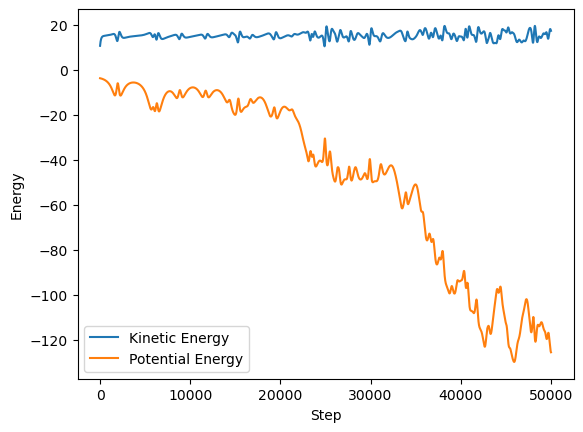

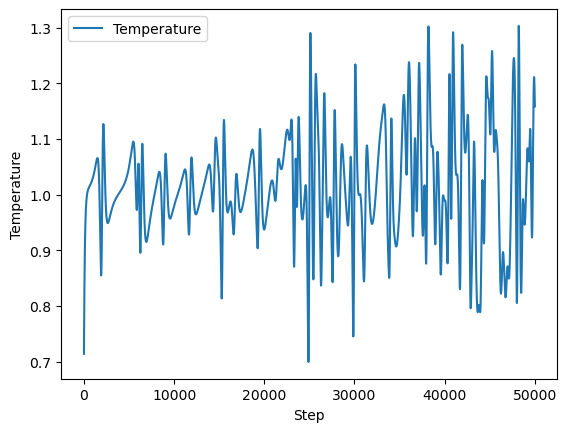

In [18]:
# User input for simulation parameters
# note that these are reduced units - as in they are unitless!
epsilon = 10.0 # 10 will give sticky particles that clump together
sigma = 1.0 # make this whatever size you would like to try!
mass = 1.0 # Hydrogen :) 
dt = 0.0001 # small values! You can play around with this number and see what happens
num_particles = 10 # this code is not very optimized so big numbers will not run efficiently
density = 0.01 # this is how dense our system will be
temperature = 1 # in reduced units :) 
num_steps = 50000 # play around!

# Run simulation
kinetic_energy, potential_energy, total_energy, temperature_array = velocity_verlet_berendsen(num_particles, num_steps, temperature, density)

# Visualization 
plt.plot(kinetic_energy, label='Kinetic Energy')
plt.plot(potential_energy, label='Potential Energy')
#plt.plot(total_energy, label='Total Energy')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.plot(temperature_array, label='Temperature')
plt.xlabel('Step')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Homework for the reader
This code will run simulations with "good starts" (where energies are reasonable values) 
and "bad starts" (where energies are incredibly large). 
Why do you think this is? (Hint: Did we take any precautions
when assigning the initial coordinates of the particles?) What could you add to the code to 
attempt to remedy this?

How could one control the pressure? The ambitious reader could attemp to code the 
Monte Carlo barostat (https://www.ks.uiuc.edu/Research/namd/3.0/ug/node39.html)

As the system size gets bigger (>1000 particles) what could one do to reduce computational burden?


